In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet

# Replicate Dr. Schrier's Code

In [3]:
lead_stock = [0.01, 0]
iodine_stock = [0.0, 0.01]
water = [0,0]

ksp = 1.4*10**(-8)

In [3]:
def dist_in_hull(points, n):
    dims = points.shape[-1]
    hull = points[ConvexHull(points).vertices]
    deln = points[Delaunay(hull).simplices]

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims)    
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

In [87]:
# generate 24 random experiments 
# not seeded, save output

#r_exps = dist_in_hull(np.array([lead_stock,iodine_stock,water]), 24)
r_exps = np.array(pd.read_fwf('24_r_exps.txt'))
pool = np.array(pd.read_csv('pool.csv'))

In [88]:
def pbI2Precipitates(pb, iodine, Ksp = 1.4*10**(-8)):
    return (iodine >= np.sqrt(Ksp/pb))

In [89]:
bools = np.array([pbI2Precipitates(r_exps[i][0], r_exps[i][1]) for i in range(len(r_exps))])

In [90]:
trues = r_exps[list(np.where(bools == True)[0])]
falses = r_exps[list(np.where(bools == False)[0])]

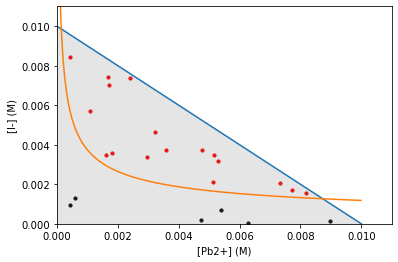

In [91]:
plt.scatter(trues[:,0], trues[:,1], c='r', s=10)
plt.scatter(falses[:,0], falses[:,1], c='k', s=10)
plt.fill_between([0, 0.010], [0.010, 0], 0,
                 facecolor="orange", 
                 color='grey',       
                 alpha=0.2)
plt.plot([0, 0.010], [0.010, 0])
plt.axis([0, 0.011, 0, 0.011])
plt.xlabel('[Pb2+] (M)')
plt.ylabel('[I-] (M)')
plt.plot(list(np.arange(10**(-5), 0.01, 0.00001)), [np.sqrt(ksp/pb) for pb in np.arange(10**(-5), 0.01, 0.00001)])

plt.show()

# All Data Linear SVM on Log Data

In [92]:
X = np.log(r_exps)
Y = bools.astype(int)

In [93]:
# fit the model

clf_all = svm.SVC(kernel='linear')
clf_all.fit(X, Y) 

SVC(kernel='linear')

In [94]:
# get hyperplane

w = clf_all.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-9, -4)
yy = a * xx - (clf_all.intercept_[0] / w[1])

In [95]:
b = clf_all.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf_all.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

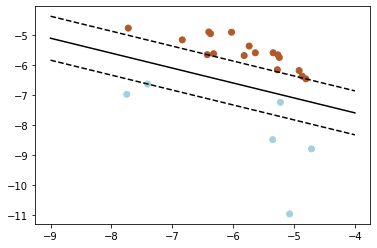

In [96]:
# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf_all.support_vectors_[:, 0], clf_all.support_vectors_[:, 1],
            s=80, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

plt.axis('tight')
plt.show()

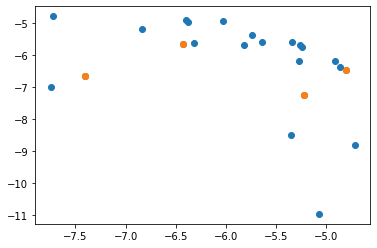

In [97]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(clf_all.support_vectors_[:,0], clf_all.support_vectors_[:,1])

## Active Learning SVM

# How to cluster the state space 

In [5]:
# import state space
state_space = np.array(pd.read_csv('possible.CSV'))

## Elbow Method

In [14]:
# do the elbow method analysis for the state space 

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10) # max cluster number is basically arbitrary 

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(state_space)
    kmeanModel.fit(state_space)
    
    distortions.append(sum(np.min(cdist(state_space,kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / state_space.shape[0])

    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(state_space, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / state_space.shape[0]

    mapping2[k] = kmeanModel.inertia_

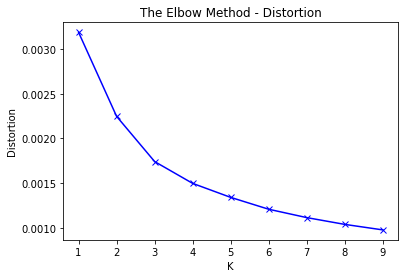

In [20]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method - Distortion')
plt.show()

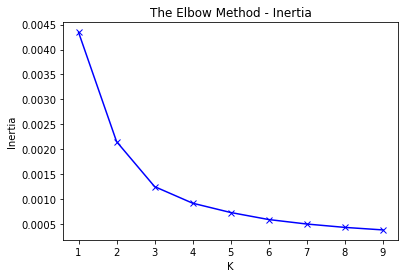

In [21]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('The Elbow Method - Inertia')
plt.show()

## Silhouette Score

In [13]:
k_range = range(2, 10)

In [27]:
# silhouette score is (b - a) / max(a, b) where a is the mean intra-cluster distance and b is the mean nearest-cluster distance 

for n in k_range:
    clusterer = KMeans(n_clusters=n)
    cluster_labels = clusterer.fit_predict(state_space)

    sil_avg = metrics.silhouette_score(state_space, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score is :", sil_avg)

    sample_silhouette_values = metrics.silhouette_samples(state_space, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.41999285350574594
For n_clusters = 3 The average silhouette_score is : 0.4304035685977791
For n_clusters = 4 The average silhouette_score is : 0.4122257728367312
For n_clusters = 5 The average silhouette_score is : 0.3673320234963857
For n_clusters = 6 The average silhouette_score is : 0.3735793953054813
For n_clusters = 7 The average silhouette_score is : 0.38029204930382327
For n_clusters = 8 The average silhouette_score is : 0.36242174814165024
For n_clusters = 9 The average silhouette_score is : 0.3519770579633644


In [ ]:
# silhouette score corroborates 7 

# 3D Cluster Analysis

In [11]:
pool3D = pd.read_csv("poolCont3D.csv", header=None)

In [14]:

for n in k_range:
    clusterer = KMeans(n_clusters=n)
    cluster_labels = clusterer.fit_predict(pool3D)

    sil_avg = metrics.silhouette_score(pool3D, cluster_labels)
    print("For n_clusters =", n, "The average silhouette_score is :", sil_avg)

    sample_silhouette_values = metrics.silhouette_samples(pool3D, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.28201412313357516
For n_clusters = 3 The average silhouette_score is : 0.353998866698722
For n_clusters = 4 The average silhouette_score is : 0.3350671613762895
For n_clusters = 5 The average silhouette_score is : 0.3128697298406603
For n_clusters = 6 The average silhouette_score is : 0.30323152079232657
For n_clusters = 7 The average silhouette_score is : 0.3289969977589934
For n_clusters = 8 The average silhouette_score is : 0.3170117595708823
For n_clusters = 9 The average silhouette_score is : 0.30966928035693564
